##Plan:
- Estimate rate of transmission (beta) for covid in LA
- Attempt to reduce MSE to get closer to true beta
- Analyze different epochs in 2020 to study the fluctuation of beta.

##Dataset:
https://www.kaggle.com/fireballbyedimyrnmom/us-counties-covid-19-dataset/discussion/141174

In [ ]:
#set up to use kaggle data without downloading it
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"erixyz","key":"fad7020df7aad0ea2246d96fae3c64d8"}'}

In [ ]:
#check to see if file is uploaded
!ls -lha kaggle.json

-rw-r--r-- 1 root root 62 Jan  6 23:37 kaggle.json


In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#download dataset using API
!kaggle datasets download -d fireballbyedimyrnmom/us-counties-covid-19-dataset

 66% 6.00M/9.06M [00:00<00:00, 60.0MB/s]
100% 9.06M/9.06M [00:00<00:00, 58.1MB/s]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error

In [ ]:
df = pd.read_csv("/content/us-counties-covid-19-dataset.zip")
print(df.shape)
df[:5]

(901046, 6)


,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0


In [ ]:
df.county.unique()

array(['Snohomish', 'Cook', 'Orange', ..., 'Esmeralda', 'Loving',
       'Kalawao'], dtype=object)

In [ ]:
#isolate Los Angeles county in the data set.

df2 = df[(df['county'] == 'Los Angeles')]
df2 = df2.reset_index().drop(columns="index")
df2

,date,county,state,fips,cases,deaths
0,2020-01-26,Los Angeles,California,6037.0,1,0.0
1,2020-01-27,Los Angeles,California,6037.0,1,0.0
2,2020-01-28,Los Angeles,California,6037.0,1,0.0
3,2020-01-29,Los Angeles,California,6037.0,1,0.0
4,2020-01-30,Los Angeles,California,6037.0,1,0.0
...,...,...,...,...,...,...
341,2021-01-01,Los Angeles,California,6037.0,790895,10552.0
342,2021-01-02,Los Angeles,California,6037.0,806523,10682.0
343,2021-01-03,Los Angeles,California,6037.0,818959,10773.0
344,2021-01-04,Los Angeles,California,6037.0,827843,10850.0


In [ ]:
#dates of focus can be found on https://www.nbclosangeles.com/news/local/a-coronavirus-timeline/2334100/.
#might want to consider george floyd riots in LA.
#GF riots begin 5/27 and end (on a mass scale) ~6/9

In [ ]:
#data frame with dates as an index.

ts = df2.groupby('date').sum()
ts.index = ts.index.astype('datetime64[ns]')
ts

,fips,cases,deaths
date,,,
2020-01-26,6037.0,1,0.0
2020-01-27,6037.0,1,0.0
2020-01-28,6037.0,1,0.0
2020-01-29,6037.0,1,0.0
2020-01-30,6037.0,1,0.0
...,...,...,...
2021-01-01,6037.0,790895,10552.0
2021-01-02,6037.0,806523,10682.0
2021-01-03,6037.0,818959,10773.0


Text(0.5, 0, 'Time')

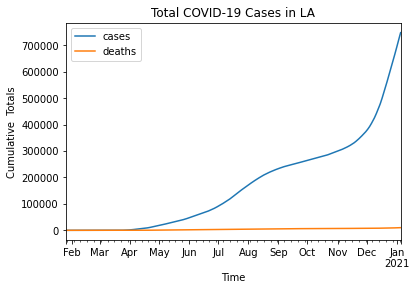

In [ ]:
ts[["cases","deaths"]].ewm(7).mean().plot()
plt.title('Total COVID-19 Cases in LA')
plt.ylabel('Cumulative  Totals')
plt.xlabel('Time')

In [ ]:
#ts['cases_delta'] = ts['cases'].diff()
#ts['deaths_delta'] = ts['deaths'].diff()
ts = ts.drop(columns = 'fips')

#notice the first 40ish days remain constant at only one case. 3/4 marks beginning of testing in LA.
la = ts[('2020-03-04'):]
la.head()

,cases,deaths
date,,
2020-03-04,7,0.0
2020-03-05,11,0.0
2020-03-06,13,0.0
2020-03-07,14,0.0
2020-03-08,14,0.0


In [ ]:
N0 = 10000000
la['susceptible'] = N0 - la.cases;

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#days for analysis:
all_days = np.linspace(1,len(la),len(la))

riots = la[('2020-05-27'):('2020-06-12')]
riot_days = np.linspace(1,len(riots),len(riots))

In [ ]:
#models:

#SI model:
def SImodel(y, days, beta, N):
  S, I = y
  dSdt = -beta * S * I * (1/N)
  dIdt = beta * S * I * (1/N)
  return dSdt, dIdt

#SIR model:
def SIRmodel(y, days, N0, beta, alpha):
    S, I, R = y
    dSdt = -beta * S * I * (1/N)
    dIdt = (1/N) * beta * S * I - alpha * I
    dRdt = alpha * I
    return dSdt, dIdt, dRdt

In [ ]:
#calculating MSE from the predicted values versus the true values:

def MSEbeta(true_values, beta_array):
  mse = []
  id = []
  for m,x in enumerate(beta_array):
    ret = odeint(SImodel, y0, all_days, args=(beta_array[m], N0))
    S, I = ret.T
    mse.append(mean_squared_error(true_values, S))
    id.append(beta_array[m])
  return mse, id

In [ ]:
#initial conditions for entirety of pandemic in LA
N0 = 10000000
I0_all = 7
S0_all = N0 - I0_all

#predictions for rates
alpha = 1/14
beta = 0.1

#actual amount of susceptible people
true_sus = np.array(la.susceptible)

In [ ]:
#utilizing the SI model:
y0 = S0_all, I0_all

ret = odeint(SImodel, y0, all_days, args=(beta, N0))
S, I = ret.T

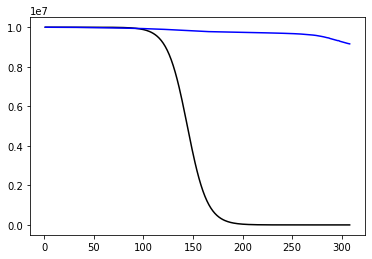

In [ ]:
plt.plot(all_days, S, color = 'black', label = 'predicted susceptible')
#plt.plot(all_days, I, color = 'red', label = 'infected');
plt.plot(all_days, true_sus, color = 'blue', label = 'actual susceptible')

In [ ]:
#attempt to find beta
beta_vals = np.linspace(0, 0.20, num = 1000)
MSE, ID = MSEbeta(true_sus ,beta_vals)
minpos = MSE.index(min(MSE))
print('beta:',ID[minpos], ' MSE:',min(MSE))

beta: 0.03983983983983984  MSE: 23213271829.47691


In [ ]:
beta_vals = np.linspace(0, 0.10, num = 1000)
MSE, ID = MSEbeta(true_sus ,beta_vals)
minpos = MSE.index(min(MSE))
print('beta:',ID[minpos], ' MSE:',min(MSE))

beta: 0.03983983983983984  MSE: 23213271829.47691


In [ ]:
beta_vals = np.linspace(0, 0.05, num = 1000)
MSE, ID = MSEbeta(true_sus ,beta_vals)
minpos = MSE.index(min(MSE))
print('beta:',ID[minpos], ' MSE:',min(MSE))

beta: 0.03983983983983984  MSE: 23213271829.47691


In [ ]:
beta_vals = np.linspace(0.025, 0.045, num = 15000)
MSE, ID = MSEbeta(true_sus ,beta_vals)
minpos = MSE.index(min(MSE))
print('beta:',ID[minpos], ' MSE:',min(MSE))

beta: 0.039339622641509434  MSE: 22900229104.893787


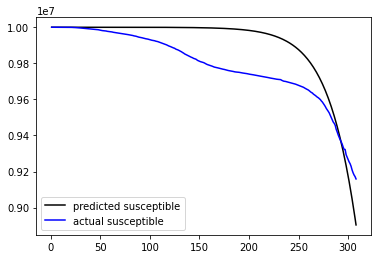

In [ ]:
beta1 = ID[minpos]
ret = odeint(SImodel, y0, all_days, args=(beta1, N0))
S, I = ret.T

plt.plot(all_days, S, color = 'black', label = 'predicted susceptible')
plt.plot(all_days, true_sus, color = 'blue', label = 'actual susceptible')
plt.legend();